## **Floorplans bedroom number prediction using resnet34**

**To use:**

> run the first cell to create the folders.
>then, upload oneurls.csc,twourls.csv,threeurls.csv,foururls.csv to floorplans folder (under data)
>then run the rest of the notebook.
>model will be saved as export.pkl

In [6]:
from fastai.vision import *
path = Path('data/floorplans')
path.mkdir(parents=True,exist_ok=True)
classes = ['one','two','three','four']

In [ ]:
for c in classes:
  folder = c
  file = c + 'urls.csv'
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)
  download_images(path/file, dest, max_pics=200)

In [ ]:

for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

In [ ]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, size=500, num_workers=4).normalize(imagenet_stats)

## Let's see that evreything is in order:

In [11]:
data.classes

['four', 'one', 'three', 'two']

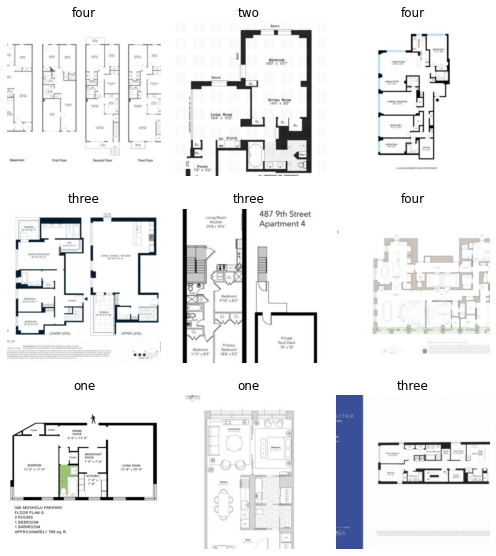

In [12]:
data.show_batch(rows=3, figsize=(7,8))

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

# Let the training begin!

In [14]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.907202,1.263005,0.485714,00:38
1,1.448720,0.903712,0.307143,00:29
2,1.074047,0.746718,0.292857,00:28
3,0.854037,0.765644,0.264286,00:27
4,0.682484,0.734714,0.250000,00:28
5,0.573167,0.724624,0.285714,00:28
6,0.473858,0.714068,0.242857,00:28
7,0.399059,0.720522,0.242857,00:27
8,0.344066,0.707930,0.235714,00:27
9,0.300693,0.707690,0.235714,00:28


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
learn.save('stage-1')

# Okay results, lets try to fine tune them using lr_finder:

In [16]:
learn.unfreeze()

In [17]:
learn.lr_find()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


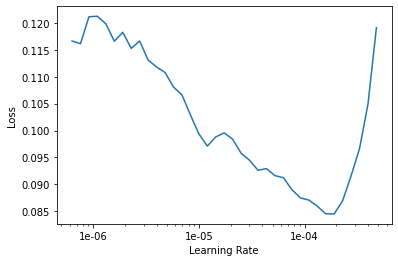

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(4, max_lr=slice(2e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.130450,0.757385,0.264286,00:48
1,0.140212,0.795580,0.257143,00:47
2,0.128143,0.753213,0.264286,00:46
3,0.109328,0.727015,0.264286,00:46


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


that's probably the best I can do with such a small dataset.

# Analysis:

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

**confusion matrix:**

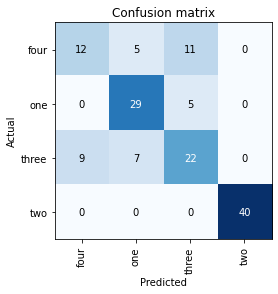

In [110]:
interp.plot_confusion_matrix()

**top losses:**

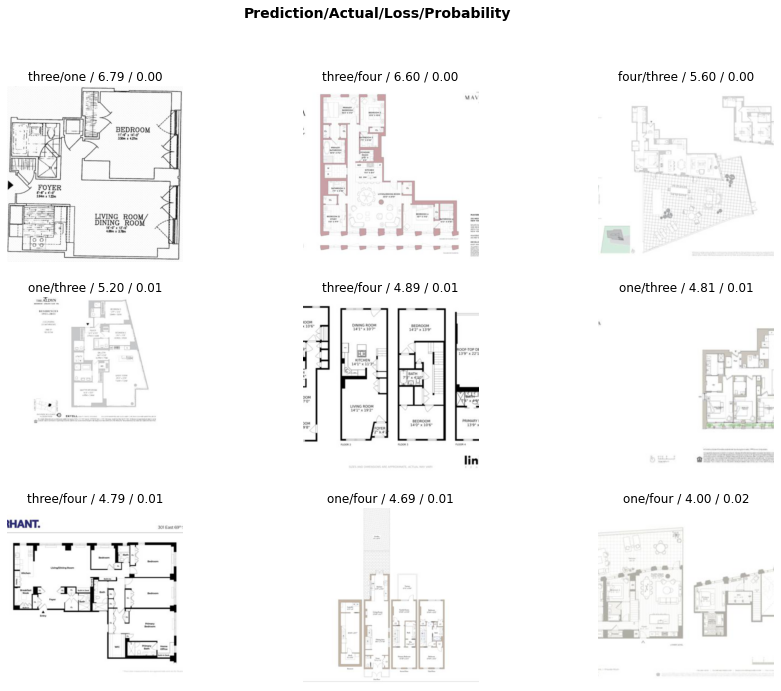

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

In [24]:
m = learn.model.eval();

**take a random image to see where our model looked:**

Category 2

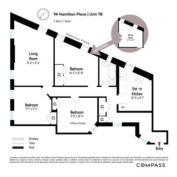

In [100]:
idx=42
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [101]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [102]:
from fastai.callbacks.hooks import *

In [103]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [107]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

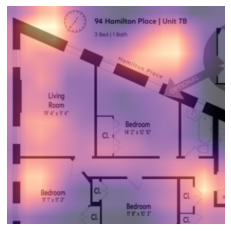

In [108]:
show_heatmap(avg_acts)

**export the model:**

In [109]:
learn.export()